In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
housing = fetch_california_housing(as_frame=True)
data = housing.frame

In [9]:
print(f"Dataset shape: {data.shape}")
print(f"Features: {housing.feature_names}")

Dataset shape: (20640, 9)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [10]:
print(data.head())
print(data.describe())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.3333

In [11]:
# Display target variable info
print(f"\nTarget variable (MedHouseVal) statistics:")
print(f"Mean: ${data['MedHouseVal'].mean() * 100000:.2f}")
print(f"Median: ${data['MedHouseVal'].median() * 100000:.2f}")
print(f"Min: ${data['MedHouseVal'].min() * 100000:.2f}")
print(f"Max: ${data['MedHouseVal'].max() * 100000:.2f}")


Target variable (MedHouseVal) statistics:
Mean: $206855.82
Median: $179700.00
Min: $14999.00
Max: $500001.00


In [12]:
# Create additional features
data['RoomsPerHousehold'] = data['AveRooms'] / data['AveOccup']
data['BedroomsPerRoom'] = data['AveBedrms'] / data['AveRooms']
data['PopulationPerHousehold'] = data['Population'] / data['AveOccup']

In [13]:
# Remove any infinite or NaN values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

In [14]:
print(f"Dataset shape after feature engineering: {data.shape}")

Dataset shape after feature engineering: (20640, 12)


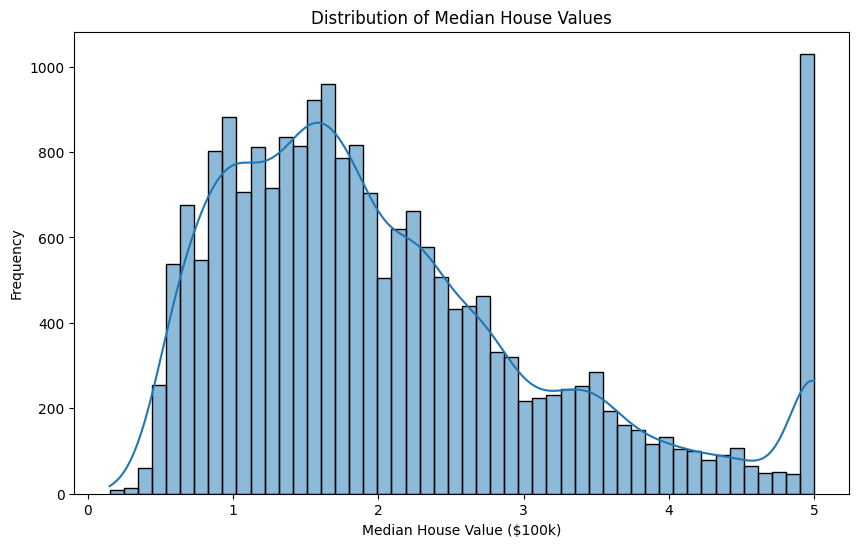

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(data['MedHouseVal'], kde=True, bins=50)
plt.title('Distribution of Median House Values')
plt.xlabel('Median House Value ($100k)')
plt.ylabel('Frequency')
plt.show()

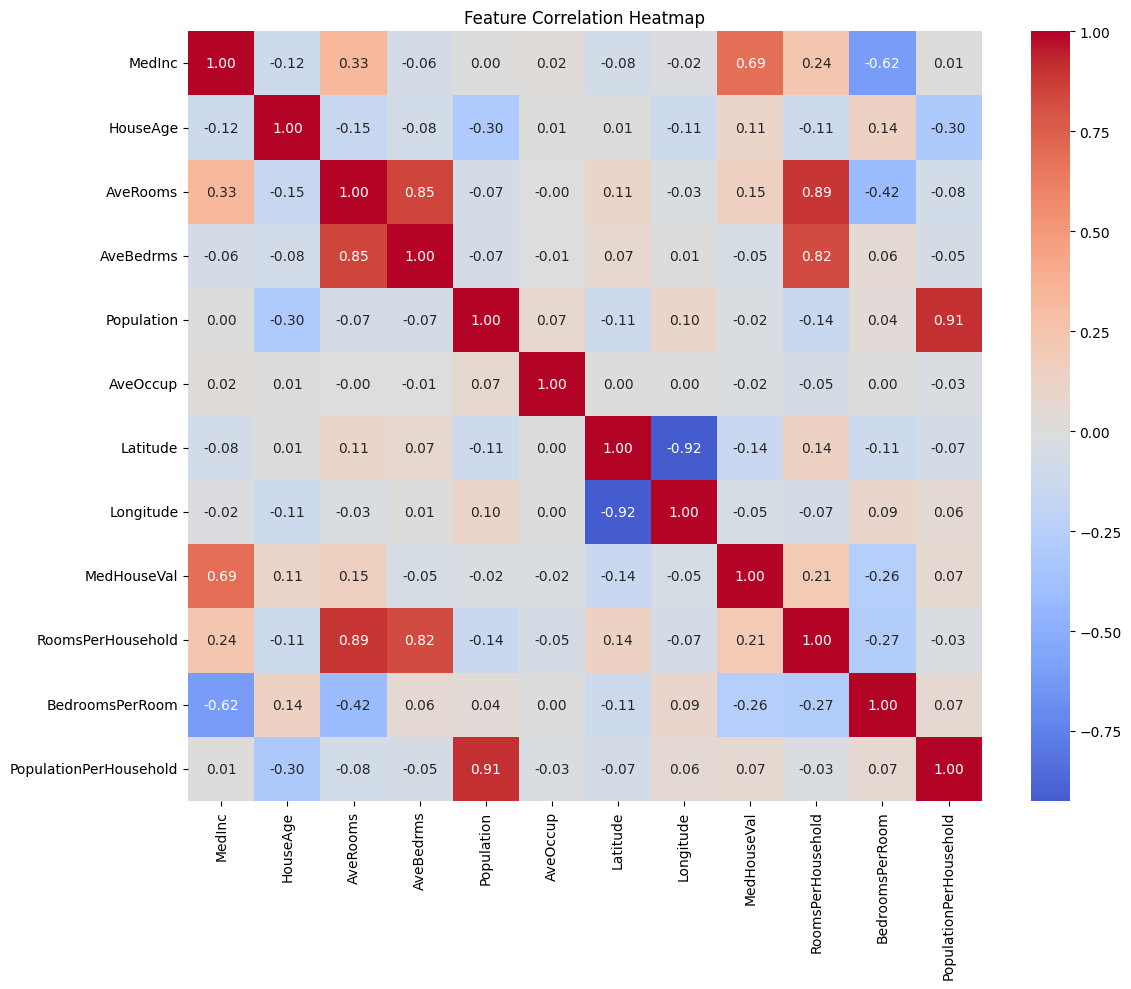

In [16]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [17]:
# %% Step 6: Check for Missing Data
print("Missing values per column:")
print(data.isna().sum())

print("\nInfinite values per column:")
print(np.isinf(data).sum())

Missing values per column:
MedInc                    0
HouseAge                  0
AveRooms                  0
AveBedrms                 0
Population                0
AveOccup                  0
Latitude                  0
Longitude                 0
MedHouseVal               0
RoomsPerHousehold         0
BedroomsPerRoom           0
PopulationPerHousehold    0
dtype: int64

Infinite values per column:
MedInc                    0
HouseAge                  0
AveRooms                  0
AveBedrms                 0
Population                0
AveOccup                  0
Latitude                  0
Longitude                 0
MedHouseVal               0
RoomsPerHousehold         0
BedroomsPerRoom           0
PopulationPerHousehold    0
dtype: int64


In [18]:
X = data.drop(["MedHouseVal"], axis=1)
y = data['MedHouseVal']

In [19]:
# Split: 60% train, 20% validation, 20% test
X_train, X_rem, y_train, y_rem = train_test_split(
    X, y, train_size=0.6, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_rem, y_rem, test_size=0.5, random_state=42
)

In [20]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 12384
Validation set size: 4128
Test set size: 4128


### Build a baseline model

In [21]:
import mlflow
import mlflow.pyfunc
import mlflow.xgboost
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlflow.models.signature import infer_signature
import cloudpickle
import time

# Create a wrapper for the XGBoost model
class XGBoostWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input):
        return self.model.predict(model_input)

# Start MLflow run for baseline model
with mlflow.start_run(run_name='baseline_xgboost'):
    # Define model parameters
    params = {
        'n_estimators': 100,
        'max_depth': 5,
        'learning_rate': 0.1,
        'random_state': 42
    }
    
    # Create and train model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions_test = model.predict(X_test)
    predictions_val = model.predict(X_val)
    
    # Calculate metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    mae_test = mean_absolute_error(y_test, predictions_test)
    r2_test = r2_score(y_test, predictions_test)
    
    rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
    mae_val = mean_absolute_error(y_val, predictions_val)
    r2_val = r2_score(y_val, predictions_val)
    
    # Log parameters
    mlflow.log_params(params)
    
    # Log metrics
    mlflow.log_metric('rmse_test', rmse_test)
    mlflow.log_metric('mae_test', mae_test)
    mlflow.log_metric('r2_test', r2_test)
    mlflow.log_metric('rmse_val', rmse_val)
    mlflow.log_metric('mae_val', mae_val)
    mlflow.log_metric('r2_val', r2_val)
    
    # Create wrapped model
    wrapped_model = XGBoostWrapper(model)
    
    # Infer signature
    signature = infer_signature(X_train, wrapped_model.predict(None, X_train))
    
    # Log model
    mlflow.pyfunc.log_model(
        "xgboost_model",
        python_model=wrapped_model,
        signature=signature,
        pip_requirements=[
            f"xgboost=={xgb.__version__}",
            f"scikit-learn=={sklearn.__version__}",
            f"cloudpickle=={cloudpickle.__version__}"
        ]
    )
    
    print(f"Test RMSE: ${rmse_test * 100000:.2f}")
    print(f"Test MAE: ${mae_test * 100000:.2f}")
    print(f"Test R²: {r2_test:.4f}")


/Users/vishaknair/Downloads/MLOps-main/Labs/Experiment_Tracking_Labs/Mlflow_Labs/Lab2/venv/lib/python3.10/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(
2025/10/30 19:50:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Users/vishaknair/Downloads/MLOps-main/Labs/Experiment_Tracking_Labs/Mlflow_Labs/Lab2/venv/lib/python3.10/site-packages/mlflow/pyfunc/__init__.py:3288: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(


Test RMSE: $49216.15
Test MAE: $32986.76
Test R²: 0.8233


In [22]:
# Get feature importances
feature_importances = pd.DataFrame(
    model.feature_importances_,
    index=X_train.columns.tolist(),
    columns=['importance']
).sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importances)

Feature Importances:
                        importance
MedInc                    0.462125
AveOccup                  0.147527
Longitude                 0.083649
Latitude                  0.067920
RoomsPerHousehold         0.066643
HouseAge                  0.054360
BedroomsPerRoom           0.044650
AveRooms                  0.027788
PopulationPerHousehold    0.017872
AveBedrms                 0.015469
Population                0.011998


<Figure size 1000x600 with 0 Axes>

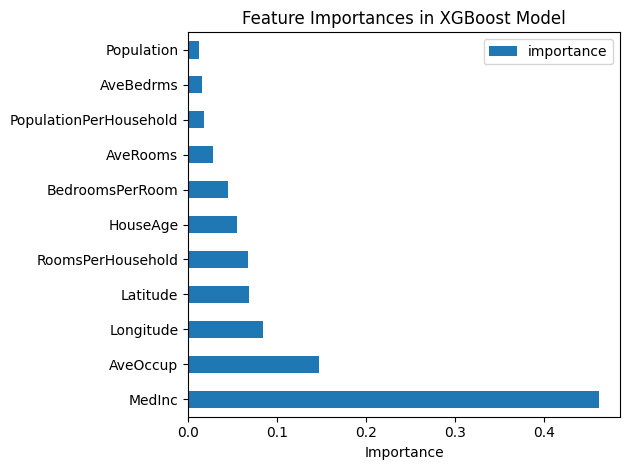

In [23]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [24]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

best_rmse = float('inf')
best_params = None

# Try different hyperparameter combinations
for n_est in param_grid['n_estimators']:
    for max_d in param_grid['max_depth']:
        for lr in param_grid['learning_rate']:
            with mlflow.start_run(run_name=f'xgb_n{n_est}_d{max_d}_lr{lr}'):
                # Train model
                params = {
                    'n_estimators': n_est,
                    'max_depth': max_d,
                    'learning_rate': lr,
                    'random_state': 42
                }
                
                model = xgb.XGBRegressor(**params)
                model.fit(X_train, y_train)
                
                # Predict and evaluate
                predictions = model.predict(X_val)
                rmse = np.sqrt(mean_squared_error(y_val, predictions))
                r2 = r2_score(y_val, predictions)
                
                # Log everything
                mlflow.log_params(params)
                mlflow.log_metric('val_rmse', rmse)
                mlflow.log_metric('val_r2', r2)
                
                # Track best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = params
                    
                print(f"n_est={n_est}, max_depth={max_d}, lr={lr} -> RMSE: {rmse:.4f}")

print(f"\nBest parameters: {best_params}")
print(f"Best validation RMSE: ${best_rmse * 100000:.2f}")

n_est=50, max_depth=3, lr=0.01 -> RMSE: 1.3192
n_est=50, max_depth=3, lr=0.1 -> RMSE: 0.5746
n_est=50, max_depth=3, lr=0.3 -> RMSE: 0.5312
n_est=50, max_depth=5, lr=0.01 -> RMSE: 1.2904
n_est=50, max_depth=5, lr=0.1 -> RMSE: 0.5264
n_est=50, max_depth=5, lr=0.3 -> RMSE: 0.4949
n_est=50, max_depth=7, lr=0.01 -> RMSE: 1.2726
n_est=50, max_depth=7, lr=0.1 -> RMSE: 0.4955
n_est=50, max_depth=7, lr=0.3 -> RMSE: 0.4887
n_est=100, max_depth=3, lr=0.01 -> RMSE: 0.9917
n_est=100, max_depth=3, lr=0.1 -> RMSE: 0.5411
n_est=100, max_depth=3, lr=0.3 -> RMSE: 0.5112
n_est=100, max_depth=5, lr=0.01 -> RMSE: 0.9354
n_est=100, max_depth=5, lr=0.1 -> RMSE: 0.4959
n_est=100, max_depth=5, lr=0.3 -> RMSE: 0.4866
n_est=100, max_depth=7, lr=0.01 -> RMSE: 0.9030
n_est=100, max_depth=7, lr=0.1 -> RMSE: 0.4767
n_est=100, max_depth=7, lr=0.3 -> RMSE: 0.4846
n_est=200, max_depth=3, lr=0.01 -> RMSE: 0.7324
n_est=200, max_depth=3, lr=0.1 -> RMSE: 0.5140
n_est=200, max_depth=3, lr=0.3 -> RMSE: 0.4979
n_est=200, max_

In [25]:
# Train Final Model with Best Parameters
with mlflow.start_run(run_name='tuned_xgboost_final'):
    # Train with best parameters
    final_model = xgb.XGBRegressor(**best_params)
    final_model.fit(X_train, y_train)
    
    # Evaluate on test set
    predictions_test = final_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    mae_test = mean_absolute_error(y_test, predictions_test)
    r2_test = r2_score(y_test, predictions_test)
    
    # Log parameters and metrics
    mlflow.log_params(best_params)
    mlflow.log_metric('final_rmse_test', rmse_test)
    mlflow.log_metric('final_mae_test', mae_test)
    mlflow.log_metric('final_r2_test', r2_test)
    
    # Create wrapped model
    wrapped_final_model = XGBoostWrapper(final_model)
    signature = infer_signature(X_train, wrapped_final_model.predict(None, X_train))
    
    # Log model
    mlflow.pyfunc.log_model(
        "xgboost_final_model",
        python_model=wrapped_final_model,
        signature=signature,
        pip_requirements=[
            f"xgboost=={xgb.__version__}",
            f"scikit-learn=={sklearn.__version__}",
            f"cloudpickle=={cloudpickle.__version__}"
        ]
    )
    
    print(f"\nFinal Model Performance on Test Set:")
    print(f"RMSE: ${rmse_test * 100000:.2f}")
    print(f"MAE: ${mae_test * 100000:.2f}")
    print(f"R² Score: {r2_test:.4f}")

2025/10/30 19:50:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Final Model Performance on Test Set:
RMSE: $46507.30
MAE: $30551.46
R² Score: 0.8423


/Users/vishaknair/Downloads/MLOps-main/Labs/Experiment_Tracking_Labs/Mlflow_Labs/Lab2/venv/lib/python3.10/site-packages/mlflow/pyfunc/__init__.py:3288: UserWarning: An input example was not provided when logging the model. To ensure the model signature functions correctly, specify the `input_example` parameter. See https://mlflow.org/docs/latest/model/signatures.html#model-input-example for more details about the benefits of using input_example.
  color_warning(


In [26]:
# Register Model in MLflow Model Registry
# Search for the tuned model run
run_id = mlflow.search_runs(
    filter_string='tags.mlflow.runName = "tuned_xgboost_final"'
).iloc[0].run_id

# Register the model
model_name = "housing_price_predictor"
model_version = mlflow.register_model(
    f"runs:/{run_id}/xgboost_final_model",
    model_name
)

# Wait for registration to complete
time.sleep(15)

print(f"Model registered as '{model_name}' with version {model_version.version}")


Successfully registered model 'housing_price_predictor'.
2025/10/30 19:50:59 WARNING mlflow.tracking._model_registry.fluent: Run with id 509e23ba52ef4ba6bbe912d17d654d7a has no artifacts at artifact path 'xgboost_final_model', registering model based on models:/m-40d452f53dc64ad3af76c927f0757780 instead
Created version '1' of model 'housing_price_predictor'.


Model registered as 'housing_price_predictor' with version 1


In [27]:
# Transition Model to Production
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=model_version.version,
    stage="Production"
)

print(f"Model version {model_version.version} transitioned to Production stage")


Model version 1 transitioned to Production stage


/var/folders/x7/fc3vnzb90sdcq1ydx20l7_9h0000gq/T/ipykernel_94077/1160434143.py:5: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [28]:
# Load production model
production_model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# Perform batch inference
batch_predictions = production_model.predict(X_test)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, batch_predictions))
mae = mean_absolute_error(y_test, batch_predictions)
r2 = r2_score(y_test, batch_predictions)

print(f"Production Model Performance:")
print(f"RMSE: ${rmse * 100000:.2f}")
print(f"MAE: ${mae * 100000:.2f}")
print(f"R² Score: {r2:.4f}")

# Show sample predictions
results_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': batch_predictions[:10],
    'Difference': y_test.values[:10] - batch_predictions[:10]
})
results_df['Actual'] = results_df['Actual'] * 100000
results_df['Predicted'] = results_df['Predicted'] * 100000
results_df['Difference'] = results_df['Difference'] * 100000

print("\nSample Predictions (first 10):")
print(results_df)


Production Model Performance:
RMSE: $46507.30
MAE: $30551.46
R² Score: 0.8423

Sample Predictions (first 10):
     Actual      Predicted    Difference
0   41300.0   97950.289062 -56650.291634
1   69000.0   60947.531250   8052.468538
2  167500.0  227514.812500 -60014.815331
3  235900.0  216100.781250  19799.211884
4   58400.0   83880.054688 -25480.054951
5   88200.0   90328.929688  -2128.931808
6  500001.0  517830.187500 -17829.181122
7  122100.0  130263.398438  -8163.400078
8  152500.0  177356.109375 -24856.112003
9   94400.0   81118.015625  13281.982565


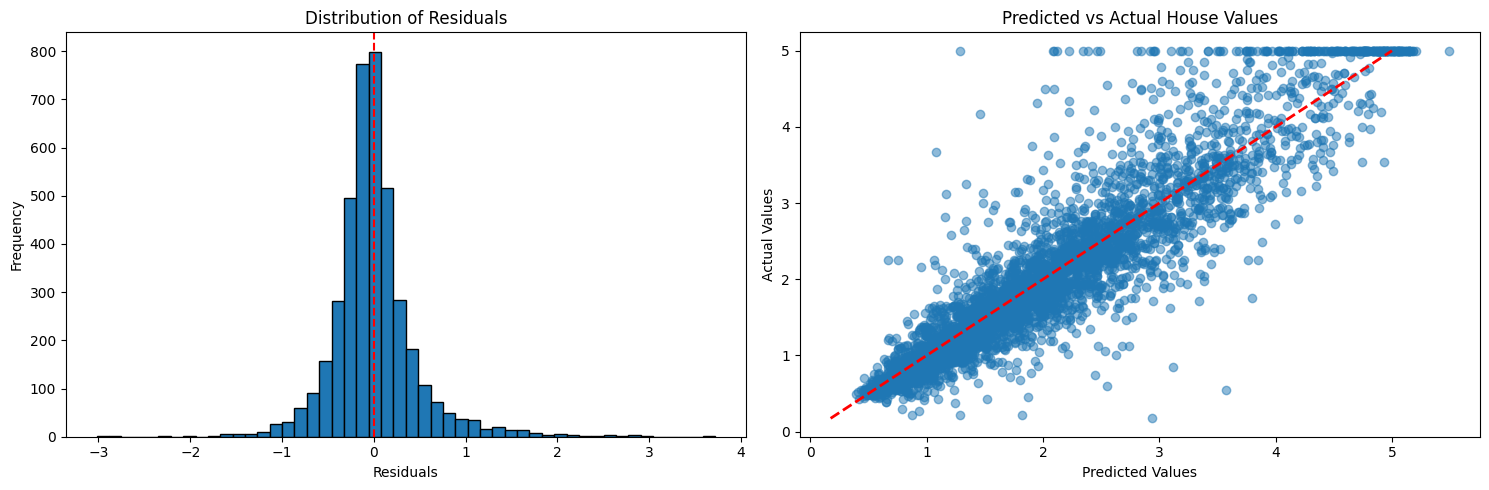

In [29]:
# Calculate residuals
residuals = y_test - batch_predictions

# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual distribution
axes[0].hist(residuals, bins=50, edgecolor='black')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Residuals')
axes[0].axvline(x=0, color='r', linestyle='--')

# Predicted vs Actual
axes[1].scatter(batch_predictions, y_test, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Actual Values')
axes[1].set_title('Predicted vs Actual House Values')

plt.tight_layout()
plt.show()

In [30]:
# Load baseline model for comparison
baseline_run_id = mlflow.search_runs(
    filter_string='tags.mlflow.runName = "baseline_xgboost"'
).iloc[0].run_id

baseline_model = mlflow.pyfunc.load_model(f"runs:/{baseline_run_id}/xgboost_model")
baseline_predictions = baseline_model.predict(X_test)

# Calculate metrics for both models
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
tuned_rmse = np.sqrt(mean_squared_error(y_test, batch_predictions))

baseline_r2 = r2_score(y_test, baseline_predictions)
tuned_r2 = r2_score(y_test, batch_predictions)

# Display comparison
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'R² Score'],
    'Baseline Model': [f'${baseline_rmse * 100000:.2f}', f'{baseline_r2:.4f}'],
    'Tuned Model': [f'${tuned_rmse * 100000:.2f}', f'{tuned_r2:.4f}'],
    'Improvement': [
        f'{((baseline_rmse - tuned_rmse) / baseline_rmse * 100):.2f}%',
        f'{((tuned_r2 - baseline_r2) / baseline_r2 * 100):.2f}%'
    ]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

/Users/vishaknair/Downloads/MLOps-main/Labs/Experiment_Tracking_Labs/Mlflow_Labs/Lab2/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Comparison:
  Metric Baseline Model Tuned Model Improvement
    RMSE      $49216.15   $46507.30       5.50%
R² Score         0.8233      0.8423       2.30%


In [ ]:
# Test Real-Time Inference (run after serving the model)
import requests
import json

# Prepare sample data for prediction
sample_data = X_test.head(5)

# Format data for API request
data_dict = {
    "dataframe_split": sample_data.to_dict(orient='split')
}

# Send prediction request
url = 'http://localhost:5001/invocations'

try:
    response = requests.post(url, json=data_dict)
    
    if response.status_code == 200:
        predictions = response.json()
        print("Predictions from deployed model:")
        for i, pred in enumerate(predictions):
            print(f"Sample {i+1}: ${pred * 100000:.2f}")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
except requests.exceptions.ConnectionError:
    print("Model server is not running. Start it with:")
    print("mlflow models serve --env-manager=local -m models:/housing_price_predictor/production -h 0.0.0.0 -p 5001")


Model server is not running. Start it with:
mlflow models serve --env-manager=local -m models:/housing_price_predictor/production -h 0.0.0.0 -p 5001


In [35]:
!mlflow ui --port=5001

[MLflow] Security middleware enabled with default settings (localhost-only). To allow connections from other hosts, use --host 0.0.0.0 and configure --allowed-hosts and --cors-allowed-origins.
INFO:     Uvicorn running on http://127.0.0.1:5001 (Press CTRL+C to quit)
INFO:     Started parent process [42288]
INFO:     Started server process [42290]
INFO:     Started server process [42291]
INFO:     Waiting for application startup.
INFO:     Waiting for application startup.
INFO:     Started server process [42293]
INFO:     Started server process [42292]
INFO:     Waiting for application startup.
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Application startup complete.
INFO:     Application startup complete.
INFO:     Application startup complete.
INFO:     127.0.0.1:62661 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:62661 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=5&order_by=last_update_time+DESC HTTP/1.1" 200 OK
INFO:    